In [1]:
%matplotlib widget

In [2]:
import requests as rq
import csv
import pandas as pd
import numpy as np
import plotly.express as px
import os
import plotly.graph_objects as go

In [3]:
# update database
# # cloned from https://github.com/CSSEGISandData/COVID-19
import os
if not os.path.exists('../COVID-19'):
    print('cloning data repository.')
    std_out = os.system('clone-COVID.sh')
std_out = os.system('update-COVID-data.sh')

In [4]:
# Init Mapbox API
# Extract token
mapbox_token = os.getenv("MAPBOX_API_KEY")
print(type(mapbox_token))

# Set token using Plotly Express set function
px.set_mapbox_access_token(mapbox_token)

<class 'str'>


In [5]:
# def read_remote_csv(url):
#     # read csv from url
#     response = rq.get(url)
#     csv_reader = csv.reader(response.text.split('\n'), delimiter=',')
#     header = next(csv_reader)

#     csv_data = [row for row in csv_reader]
#     return (header, csv_data)

def read_local_csv(file_path):
    # read csv from url
    with open(file_path,'rt') as file:
        csv_reader = csv.reader(file, delimiter=',')
        header = next(csv_reader)

        csv_data = [row for row in csv_reader]
        
    jh_data = pd.DataFrame.from_records(csv_data, columns=header)    
    return jh_data

In [6]:
#ny_times_timeseries_url = r'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

# John's Hopkins
# https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports/03-31-2020.csv # regular format

In [7]:
# # NY Times data
# header, csv_data = read_remote_csv(ny_times_timeseries_url)
# case_data = pd.DataFrame.from_records(data=csv_data,columns=header)
# case_data['date'] = pd.to_datetime(case_data['date'])
# case_data[['cases','deaths']] = case_data[['cases','deaths']].applymap(int)
# case_data.head()

In [8]:
# case_data.pivot_table(index='date', columns='state', values='cases', aggfunc=sum).plot.line(figsize=(15,15))


In [9]:
daily_data_path = r'../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports'
data_files = sorted(os.listdir(daily_data_path))
data_dates = pd.to_datetime([file[0:10] for file in data_files if file[10:]=='.csv'])

last_date = data_dates.max()

In [10]:
def read_jh_data(date):
    
    datestr = date.strftime('%m-%d-%Y')
    filename = f'{datestr}.csv'
    
    last_file_path = os.path.join(daily_data_path, filename)
    
    jh_data = read_local_csv(last_file_path)
    jh_data['Date'] = date

    #jh_data[['Lat','Long_','Confirmed','Deaths','Recovered','Active']] = jh_data[['Lat','Long_','Confirmed','Deaths','Recovered','Active']].applymap(lambda x: float(x) if x != "" else np.nan)
    
    return jh_data

In [11]:
jh_lastday = read_jh_data(last_date)
jh_lastday.head()

FIPS     Admin2  Province_State Country_Region          Last_Update  \
0  45001  Abbeville  South Carolina             US  2020-04-02 23:25:27   
1  22001     Acadia       Louisiana             US  2020-04-02 23:25:27   
2  51001   Accomack        Virginia             US  2020-04-02 23:25:27   
3  16001        Ada           Idaho             US  2020-04-02 23:25:27   
4  19001      Adair            Iowa             US  2020-04-02 23:25:27   

                  Lat                Long_ Confirmed Deaths Recovered Active  \
0         34.22333378         -82.46170658         6      0         0      0   
1  30.295064899999996         -92.41419698        61      1         0      0   
2         37.76707161         -75.63234615        10      0         0      0   
3          43.4526575  -116.24155159999998       312      3         0      0   
4         41.33075609         -94.47105874         1      0         0      0   

                    Combined_Key       Date  
0  Abbeville, South Carolina, US 2020-04-02  
1          Acadia, Louisiana, US 2020-04-02  
2         Accomack, Virginia, US 2020-04-02  
3                 Ada, Idaho, US 2020-04-02  
4                Adair, Iowa, US 2020-04-02

In [12]:

all_days = pd.concat([read_jh_data(dt) for dt in data_dates])

all_days[['Lat','Long_','Confirmed','Deaths','Recovered','Active']] = all_days[['Lat','Long_','Confirmed','Deaths','Recovered','Active']].applymap(lambda x: float(x) if x != "" else np.nan)

In [13]:
all_days.shape

(45927, 20)

In [14]:
us_data = all_days.loc[(all_days['Country_Region']=='US')&(all_days['Date']==last_date),:]

In [15]:
us_data.head().dtypes

ï»¿Province/State            object
Country/Region               object
Last Update                  object
Confirmed                   float64
Deaths                      float64
Recovered                   float64
Date                 datetime64[ns]
Province/State               object
Latitude                     object
Longitude                    object
ï»¿FIPS                      object
Admin2                       object
Province_State               object
Country_Region               object
Last_Update                  object
Lat                         float64
Long_                       float64
Active                      float64
Combined_Key                 object
FIPS                         object
dtype: object

In [16]:
# PLot US
us_scatter_map_box = px.scatter_mapbox(
    us_data,
    lat="Lat",
    lon="Long_",
    size="Confirmed",
    color="Deaths",
    hover_name='Admin2',

)

fig = go.Figure(us_scatter_map_box
)

fig.update_layout(
    mapbox=dict(
        accesstoken=mapbox_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=40,
            lon=-99
        ),
        pitch=0,
        zoom=3
    )
)

fig.write_image('maps/us_cases.png')


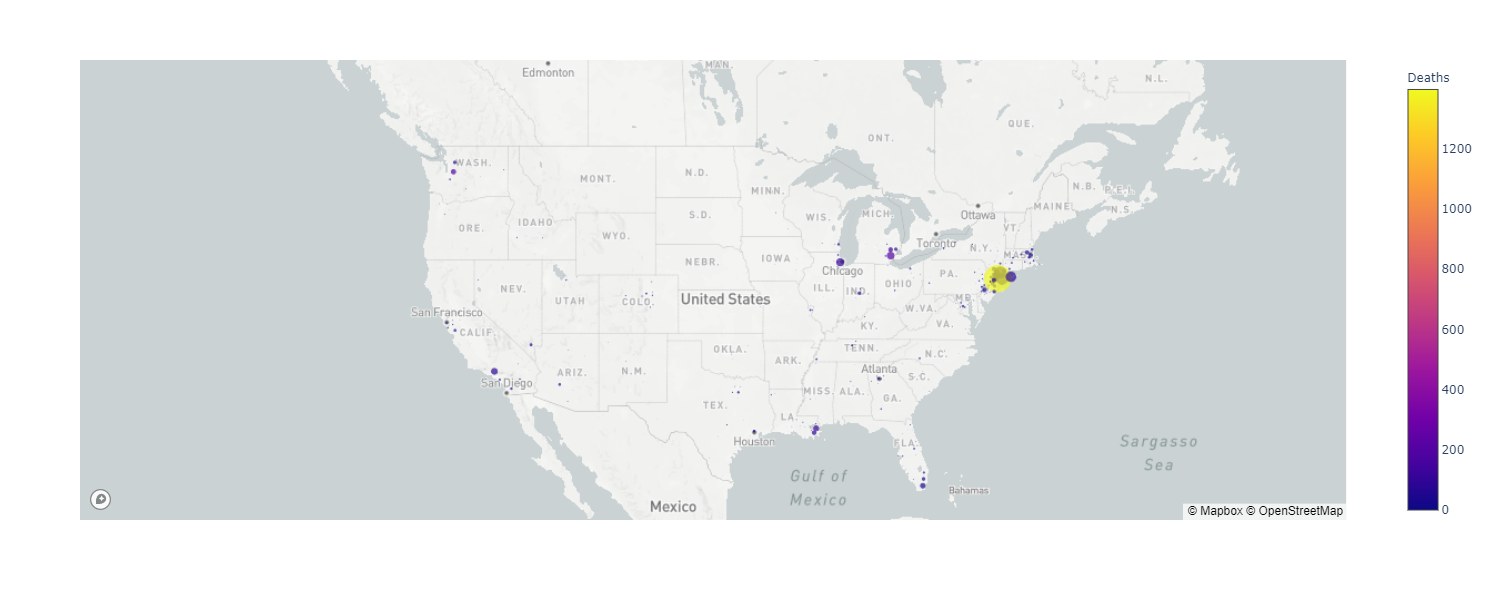

In [19]:
fig

![nz cases](maps/us_cases.png)

In [20]:
nz_data = us_data = all_days.loc[(all_days['Country_Region']=='New Zealand')&(all_days['Date']==last_date),:] 
nz_data.head()

ï»¿Province/State Country/Region Last Update  Confirmed  Deaths  \
2509               NaN            NaN         NaN      797.0     1.0   

      Recovered       Date Province/State Latitude Longitude ï»¿FIPS Admin2  \
2509       92.0 2020-04-02            NaN      NaN       NaN     NaN          

     Province_State Country_Region          Last_Update      Lat    Long_  \
2509                   New Zealand  2020-04-02 23:25:14 -40.9006  174.886   

      Active Combined_Key FIPS  
2509   704.0  New Zealand

In [21]:
nz_scatter_map_box = px.scatter_mapbox(
    nz_data,
    lat="Lat",
    lon="Long_",
    size="Confirmed",
    color="Deaths",
    hover_name='Admin2',
)


fig = go.Figure(nz_scatter_map_box
)

fig.update_layout(
    mapbox=dict(
        accesstoken=mapbox_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=-41,
            lon=174
        ),
        pitch=0,
        zoom=4.2
    )
)


fig.write_image('maps/nz_cases.png')

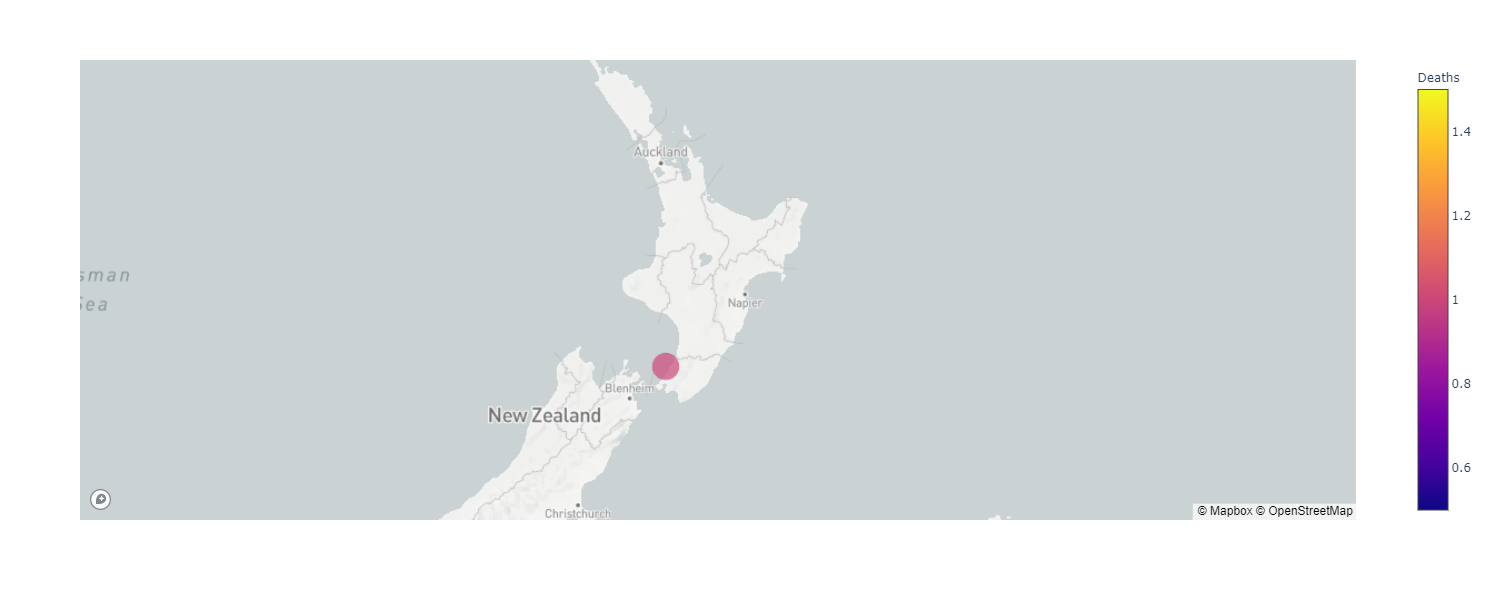

In [22]:
fig

![nz cases](maps/nz_cases.png)